# pybacktest tutorial

This tutorial will give you a quick overview of **pybacktest**'s features. To do so, we will backtest classic MA crossover trading strategy:

* go long when short MA crosses above long MA
* go short when short MA crosses below long MA
* entry rules are also exit rules, thus making strategy reversible

Package is available for download at https://github.com/zluo/pybacktest

In [1]:
import pybacktest  # obviously, you should install pybacktest before importing it
import pandas as pd

**pybacktest** expects bars to be in `pandas.DataFrame` indexed by datetimestamps, with columns named `O`, `H`, `L`, `C`. Actually, in this version it would only check `O`, and only if trade prices are not explicitly specified.

Lets load data from yahoo using helper.

In [2]:
ohlc = pybacktest.load_from_yahoo('SPY')
ohlc

O       H       L       C          V      AC
Date                                                         
2013-04-22  155.78  156.54  154.75  156.17  106501600  156.17
2013-04-23  156.95  157.93  156.17  157.78  165950600  157.78
2013-04-24  157.83  158.30  157.54  157.88   96724000  157.88
2013-04-25  158.34  159.27  158.10  158.52  130916000  158.52
2013-04-26  158.33  158.60  157.73  158.24   95904500  158.24

Now time to define strategy. To do so, all we need to do is to create binary `Series` with signals, and, optionally, trade price `Series` with float elements.

Could this be any simpler?

In [3]:
short_ma = 50
long_ma = 200

ms = pandas.rolling_mean(ohlc.C, short_ma)
ml = pandas.rolling_mean(ohlc.C, long_ma)
    
buy = cover = (ms > ml) & (ms.shift() < ml.shift())  # ma cross up
sell = short = (ms < ml) & (ms.shift() > ml.shift())  # ma cross down

print '>  Short MA\n%s\n' % ms.tail()
print '>  Long MA\n%s\n' % ml.tail()
print '>  Buy/Cover signals\n%s\n' % buy.tail()
print '>  Short/Sell signals\n%s\n' % sell.tail()

>  Short MA
Date
2013-04-22    154.5438
2013-04-23    154.6634
2013-04-24    154.7856
2013-04-25    154.9156
2013-04-26    155.0374

>  Long MA
Date
2013-04-22    145.50725
2013-04-23    145.60910
2013-04-24    145.71455
2013-04-25    145.82970
2013-04-26    145.94430

>  Buy/Cover signals
Date
2013-04-22    False
2013-04-23    False
2013-04-24    False
2013-04-25    False
2013-04-26    False

>  Short/Sell signals
Date
2013-04-22    False
2013-04-23    False
2013-04-24    False
2013-04-25    False
2013-04-26    False



Time to run backtest. `Backtest` will try to extract signals and prices and bars from whatever dict-like object you passed as first argument. Could be dict, could be pandas.DataFrame or anything.

To make thing easier, pass local namespace (extracted py calling `locals()`), that contains every variable you created up to this point.

In [4]:
bt = pybacktest.Backtest(locals(), 'ma_cross')

`Backtest` runs lazily, i.e. it calculates anything only when you call properties from it. There properties: 

In [5]:
print filter(lambda x: not x.startswith('_'), dir(bt))
print '\n>  bt.signals\n%s' % bt.signals.tail()
print '\n>  bt.trades\n%s' % bt.trades.tail()
print '\n>  bt.positions\n%s' % bt.positions.tail()
print '\n>  bt.equity\n%s' % bt.equity.tail()
print '\n>  bt.trade_price\n%s' % bt.trade_price.tail()

['dataobj', 'default_price', 'eqplot', 'equity', 'name', 'ohlc', 'plot_equity', 'plot_trades', 'positions', 'prices', 'report', 'run_time', 'signals', 'sigplot', 'summary', 'trade_price', 'trades', 'trdplot']

>  bt.signals
              Buy  Cover   Sell  Short
Date                                  
2013-04-22  False  False  False  False
2013-04-23  False  False  False  False
2013-04-24  False  False  False  False
2013-04-25  False  False  False  False
2013-04-26  False  False  False  False

>  bt.trades
            pos   price  vol
Date                        
2009-06-23    1   90.16    2
2010-07-06   -1  103.13   -2
2010-10-22    1  119.14    2
2011-08-12   -1  119.19   -2
2012-01-31    1  132.29    2

>  bt.positions
Date
2009-06-23    1
2010-07-06   -1
2010-10-22    1
2011-08-12   -1
2012-01-31    1

>  bt.equity
Date
2009-06-23    58.66
2010-07-06    12.97
2010-10-22   -16.01
2011-08-12     0.05
2012-01-31   -13.10

>  bt.trade_price
Date
2013-04-22    156.95
2013-04-23    157.83

Some of popular performance statistics could be requested by calling `summary` method of `Backtest`.

In [6]:
bt.summary()

Backtest('ma_cross', 2013-28-04 23:14:15 MSK) performance summary
backtest:
  days: 6348
  from: '1994-09-14 00:00:00'
  to: '2012-01-31 00:00:00'
  trades: 17
exposure:
  holding periods:
    max: 1476 days, 0:00:00
    median: 354 days, 0:00:00
    min: 7 days, 0:00:00
  trades/month: 1.0625
performance:
  PF: 4.017
  RF: 6.1555
  averages:
    gain: 23.817
    loss: -8.47
    trade: 10.5224
  payoff: 2.8119
  profit: 178.88
  winrate: 0.5882
risk/return profile:
  UPI: 1.0656
  WCDD (monte-carlo 0.99 quantile): 52.09
  maxdd: 74.67
  sharpe: 0.4485
  sortino: 1.6792

-----------------------------------------------------------------


Now lets look at equity curve.

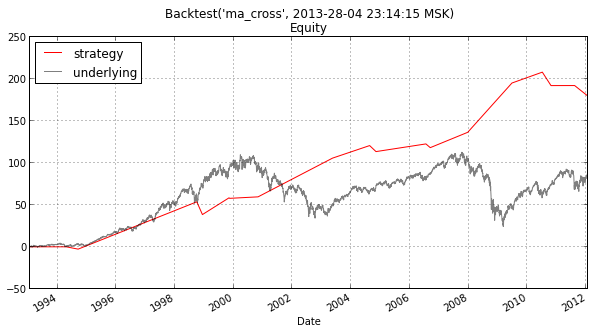

In [7]:
figsize(10, 5)
bt.plot_equity()

But what if you want to see what exactly was going on during backtest run? Well, `Backtest` can plot trades as they happened for you. Legend is hidden by default to save space.

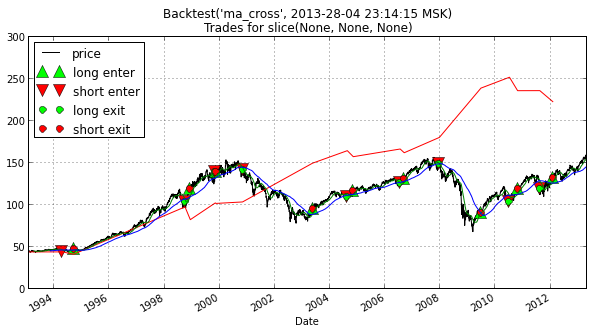

In [8]:
bt.plot_trades()
pandas.rolling_mean(ohlc.C, short_ma).plot(c='green')
pandas.rolling_mean(ohlc.C, long_ma).plot(c='blue')
legend(loc='upper left')

Can you see anything there? I can't. That's why we have special a very special `trdplot` property, which allowes you specify what period do you want to plot using standard `pandas` indexing mechanisms. Same trick could be done with equity curve using `eqplot` property.

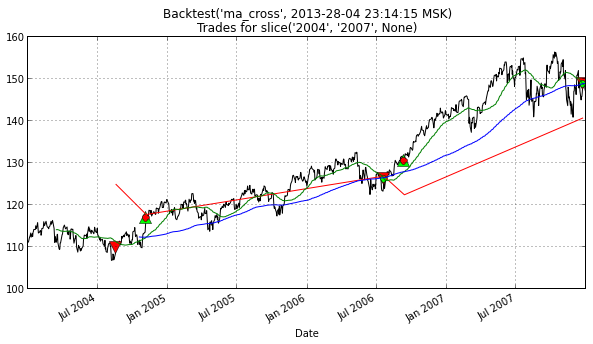

In [9]:
bt.trdplot['2004':'2007']
pandas.rolling_mean(ohlc.C['2004':'2007'], short_ma).plot(c='green')
pandas.rolling_mean(ohlc.C['2004':'2007'], long_ma).plot(c='blue')

That's the most of it. Next tutorial would be on more advanced features.